In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial import distance_matrix
import itertools
import scipy.sparse as sp
from tqdm import tqdm
import operator
import functools
import yaml
import math

In [2]:
import logging as l

l.basicConfig(level=l.INFO)

In [3]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [4]:
from data.construct import load_data_from_configuration, load_base_data_from_configuration
import configuration
import data.constants as dc

In [5]:
config = configuration.DataConfiguration(
    dataset='ogbn_arxiv', 
    preprocessing='none',
    type='npz',
    #preprocessing='word_embedding',
    #language_model = 'bert-base-uncased',
    #language_model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    #language_model = 'allenai/longformer-base-4096',
    drop_train_vertices_portion = 0.1,
)

In [6]:
if config.dataset == 'cora_full':
    config.base_labels = ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks','Artificial_Intelligence/Machine_Learning/Rule_Learning','Artificial_Intelligence/Machine_Learning/Reinforcement_Learning','Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance']

In [7]:
config

DataConfiguration(dataset='ogbn_arxiv', train_portion=20, val_portion=20, test_portion_fixed=1.0, base_labels='all', train_labels='all', corpus_labels='all', left_out_class_labels=[], max_attempts_per_split=5, drop_train_vertices_portion=0.1, setting='transductive', ood_type='perturbations', ood_sampling_strategy='all', split_type='uniform', type='npz', perturbation_budget=0.1, min_token_frequency=10, preprocessing='none', language_model='bert-base-uncased', normalize='l2', vectorizer='tf-idf', integrity_assertion=True)

In [8]:
import data.npz

npz_data = np.load(data.npz.NpzDataset.raw_files[config.dataset], allow_pickle=True)
list(npz_data.keys())

['adj_data',
 'adj_indices',
 'adj_indptr',
 'adj_shape',
 'attr_text',
 'features',
 'labels',
 'year',
 'idx_to_class',
 'idx_to_node',
 'mask_train',
 'mask_val',
 'mask_test']

In [9]:
from data.split import _make_base_data
_, _, mask_fixed, mask_non_fixed, x_base, edge_index_base, y_base, vertex_to_idx_base, label_to_idx_base, base_labels, train_labels, \
    left_out_class_labels = _make_base_data(load_base_data_from_configuration(config), config)


INFO:root:Data Loading - Loaded adjacency matrix.
INFO:root:Data Loading - Built attribute matrix.


In [10]:
{*zip(*np.unique(np.load(data.npz.NpzDataset.raw_files[config.dataset], allow_pickle=True)['labels'], return_counts=True))}

{(0, 565),
 (1, 687),
 (2, 4839),
 (3, 2080),
 (4, 5862),
 (5, 4958),
 (6, 1618),
 (7, 589),
 (8, 6232),
 (9, 2820),
 (10, 7869),
 (11, 750),
 (12, 29),
 (13, 2358),
 (14, 597),
 (15, 403),
 (16, 27321),
 (17, 515),
 (18, 749),
 (19, 2877),
 (20, 2076),
 (21, 393),
 (22, 1903),
 (23, 2834),
 (24, 22187),
 (25, 1257),
 (26, 4605),
 (27, 4801),
 (28, 21406),
 (29, 416),
 (30, 11814),
 (31, 2828),
 (32, 411),
 (33, 1271),
 (34, 7867),
 (35, 127),
 (36, 3524),
 (37, 2369),
 (38, 1507),
 (39, 2029)}

In [11]:
{*zip(*np.unique(y_base, return_counts=True))}

{(0, 565),
 (1, 687),
 (2, 4839),
 (3, 2080),
 (4, 5862),
 (5, 4958),
 (6, 1618),
 (7, 589),
 (8, 6232),
 (9, 2820),
 (10, 7869),
 (11, 750),
 (12, 29),
 (13, 2358),
 (14, 597),
 (15, 403),
 (16, 27321),
 (17, 515),
 (18, 749),
 (19, 2877),
 (20, 2076),
 (21, 393),
 (22, 1903),
 (23, 2834),
 (24, 22187),
 (25, 1257),
 (26, 4605),
 (27, 4801),
 (28, 21406),
 (29, 416),
 (30, 11814),
 (31, 2828),
 (32, 411),
 (33, 1271),
 (34, 7867),
 (35, 127),
 (36, 3524),
 (37, 2369),
 (38, 1507),
 (39, 2029)}

In [12]:
n = x_base.shape[0]
A = sp.coo_matrix((np.ones(edge_index_base.shape[1]), edge_index_base), shape=(n, n)).tocsr()

In [13]:
# Calculate community affiliation matrix
num_classes = y_base.max() + 1
communities_num_edges = np.zeros((num_classes, num_classes), dtype=int)
for i, j in itertools.product(range(num_classes), repeat=2):
    communities_num_edges[i, j] = A[y_base == i][:, y_base == j].nnz


In [14]:
class_names = [None for _ in range(num_classes)]
for label, idx in label_to_idx_base.items():
    class_names[idx] = label
class_names = np.array(class_names)


# Row normalized community affiliations

<AxesSubplot:>

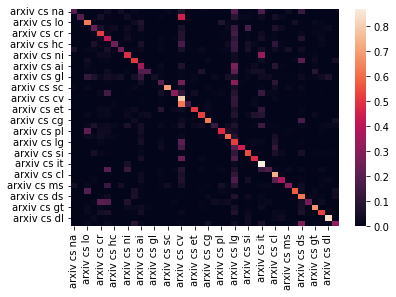

In [15]:
# Row normalize
communities_num_edges_norm = communities_num_edges / communities_num_edges.sum(1)[:, None]
sns.heatmap(pd.DataFrame(communities_num_edges_norm, class_names, class_names))

# Get homophily ratios between different sets of communites
### Use this to detect a suitable set of OOD classes

In [19]:
loc_size_by_dataset = {
    dc.CORA_ML : 2,
    dc.CITESEER : 2,
    dc.PUBMED : 1,
    dc.OGBN_ARXIV : 10,
    dc.COAUTHOR_CS : 3,
    dc.COAUTHOR_PHYSICS : 1,
    dc.AMAZON_COMPUTERS : 2,
    dc.AMAZON_PHOTO : 3,
}
# Number of partitions bin(num_classes, loc_size) = 
choice_size = loc_size_by_dataset[config.dataset]
print(f'{math.comb(num_classes, choice_size)} potential loc sets')

847660528 potential loc sets


In [20]:
num_samples = 1000000

In [21]:


df_part_size = []

if math.comb(num_classes, choice_size) < num_samples:
    print('Checking all potential loc sets')
    for partition in itertools.combinations(range(num_classes), choice_size):
        mask = np.zeros(num_classes, dtype=bool)
        mask[list(partition)] = True
        if mask.sum() == 0 or mask.sum() == num_classes:
            continue

        if mask.sum() > mask.shape[0] / 2:
            mask = ~mask

        num_inter = float(communities_num_edges[mask][:, ~mask].sum())
        num_intra = float(communities_num_edges[mask][:, mask].sum())

        df_part_size.append({
            'Ratio Inter' : num_inter / (num_inter + num_intra + 1e-10),
            'Ratio Intra' : num_intra / (num_inter + num_intra + 1e-10),
            'OOD' : class_names[mask].tolist(),
            })
else:
    print(f'Sampling {num_samples} random sets')
    for _ in tqdm(range(num_samples)):
        choice = np.random.choice(num_classes, size=choice_size, replace=False)

        mask = np.zeros(num_classes, dtype=bool)
        mask[list(choice)] = True

        if mask.sum() > mask.shape[0] / 2:
            mask = ~mask

        num_inter = float(communities_num_edges[mask][:, ~mask].sum())
        num_intra = float(communities_num_edges[mask][:, mask].sum())

        df_part_size.append({
            'Ratio Inter' : num_inter / (num_inter + num_intra + 1e-10),
            'Ratio Intra' : num_intra / (num_inter + num_intra + 1e-10),
            'OOD' : class_names[mask].tolist(),
            })
        
df_part_size = pd.DataFrame(df_part_size)     
        
    

Sampling 1000000 random sets


100%|██████████| 1000000/1000000 [01:35<00:00, 10473.08it/s]


In [22]:
print(df_part_size.sort_values(by='Ratio Inter', ascending=True)[:20].to_markdown())

|        |   Ratio Inter |   Ratio Intra | OOD                                                                                                                                                    |
|-------:|--------------:|--------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------|
| 531023 |     0.0573241 |      0.942676 | ['arxiv cs ai', 'arxiv cs ne', 'arxiv cs sc', 'arxiv cs cv', 'arxiv cs gr', 'arxiv cs se', 'arxiv cs lg', 'arxiv cs ro', 'arxiv cs cl', 'arxiv cs ir'] |
| 763518 |     0.0585971 |      0.941403 | ['arxiv cs ce', 'arxiv cs ai', 'arxiv cs ne', 'arxiv cs cv', 'arxiv cs sy', 'arxiv cs lg', 'arxiv cs si', 'arxiv cs ro', 'arxiv cs cl', 'arxiv cs ir'] |
| 336217 |     0.0593734 |      0.940627 | ['arxiv cs mm', 'arxiv cs ai', 'arxiv cs ne', 'arxiv cs cv', 'arxiv cs et', 'arxiv cs lg', 'arxiv cs ro', 'arxiv cs cl', 'arxiv cs ir', 'arxiv cs db'] |
| 364375 |     0.060

(array([1.79360e+04, 1.11001e+05, 2.63356e+05, 1.84697e+05, 1.10101e+05,
        1.76374e+05, 1.04482e+05, 2.96770e+04, 2.26700e+03, 1.09000e+02]),
 array([0.05732411, 0.12720342, 0.19708274, 0.26696205, 0.33684136,
        0.40672067, 0.47659999, 0.5464793 , 0.61635861, 0.68623792,
        0.75611724]),
 <BarContainer object of 10 artists>)

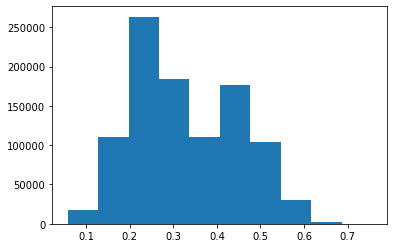

In [23]:
plt.hist(df_part_size['Ratio Inter'])